<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OLIST DATABASE

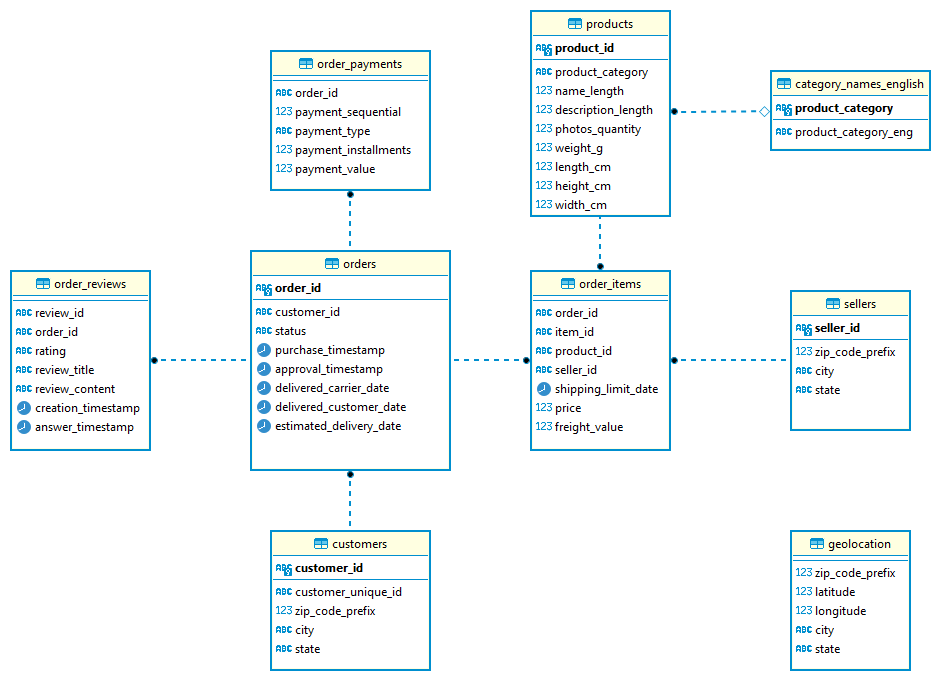

In [13]:
import pandas as pd
from sqlite3 import connect
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

## | Requêtes SQL pour le Dashboard

* En excluant les commandes annulées, quelles sont les commandes
récentes de moins de 3 mois que les clients ont reçues avec au moins 3
jours de retard ?

* Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100
000 Real sur des commandes livrées via Olist ?

* Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
produits) ?

* Question : Quels sont les 5 codes postaux, enregistrant plus de 30
reviews, avec le pire review score moyen sur les 12 derniers mois ?

In [2]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

In [3]:
db_path = f"{folder_path}olist.db"
conn = connect(db_path)
cur = conn.cursor()

## | Les tables de la base de données olist

In [4]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print(tables)

            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


## | Récupération des données

In [46]:
def extract_transform_and_load_olist_data():

  # Extract orders
  print("Extraction des commandes ...")
  orders = pd.read_sql(
    """
    SELECT
      order_id,
      order_purchase_timestamp,
      order_approved_at,
      order_delivered_carrier_date,
      order_delivered_customer_date,
      order_estimated_delivery_date
    FROM orders o
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract order items
  print("Extraction des articles ...")
  items = pd.read_sql(
    """
    SELECT
      oi.order_id,
      COUNT(order_item_id) as nbre_items,
      SUM(price+freight_value) as total_price,
      COUNT(DISTINCT oi.product_id) AS distinct_products
    FROM order_items oi
    JOIN orders o on oi.order_id=o.order_id
    WHERE o.order_status='delivered'
    GROUP BY oi.order_id
    """,
    conn
  )

  # Extract customers
  print("Extraction des clients ...")
  customers = pd.read_sql(
    """
    SELECT
      o.order_id,
      customer_unique_id,
      customer_zip_code_prefix,
      customer_city,
      customer_state
    FROM customers c
    JOIN orders o on o.customer_id = c.customer_id
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract reviews
  print("Extraction des commentaires ...")
  reviews = pd.read_sql(
    """
    SELECT
      o.order_id,
      COUNT(r.review_id) as total_reviews,
      COALESCE(AVG(r.review_score), 0) AS mean_score_review
    FROM orders o
    LEFT JOIN order_reviews r on o.order_id=r.order_id
    WHERE o.order_status='delivered'
    GROUP BY o.order_id
    """,
    conn
  )

  # Extract payments
  print("Extraction des paiments ...")
  payments = pd.read_sql(
    """
    SELECT
      p.order_id,
      MAX(payment_installments) as payment_installments
    FROM order_pymts p
    JOIN orders o on o.order_id=p.order_id
    WHERE o.order_status='delivered'
    GROUP BY p.order_id
    """,
    conn
  )
  print("--"*20)

  # Tranform

  print("Merger des items ...")
  data = orders.merge(items, on='order_id')

  print("Merger des clients ...")
  data = data.merge(customers, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(reviews, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(payments, on='order_id')

  print("--"*20)
  print(f"Dimension du dataset: {data.shape}")

  return data

In [47]:
data = extract_transform_and_load_olist_data()

Extraction des commandes ...
Extraction des articles ...
Extraction des clients ...
Extraction des commentaires ...
Extraction des paiments ...
----------------------------------------
Merger des items ...
Merger des clients ...
Merger des paiments ...
Merger des paiments ...
----------------------------------------
Dimension du dataset: (96477, 16)


In [48]:
data.dtypes

,0
order_id,object
order_purchase_timestamp,object
order_approved_at,object
order_delivered_carrier_date,object
order_delivered_customer_date,object
order_estimated_delivery_date,object
nbre_items,int64
total_price,float64
distinct_products,int64
customer_unique_id,object


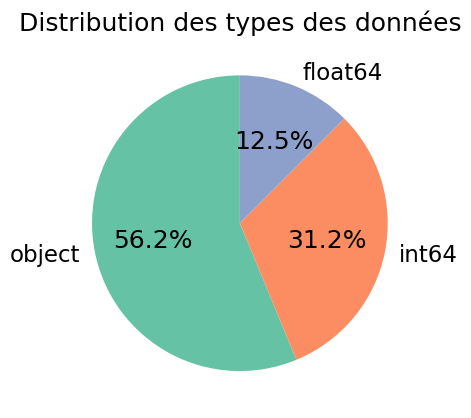

In [49]:
dtype_counts = data.dtypes.value_counts()

dtype_counts.plot.pie(autopct="%1.1f%%", labels=dtype_counts.index, startangle=90, colors=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"])
plt.title("Distribution des types des données")
plt.ylabel("")  # Remove default ylabel
plt.show()

In [8]:
data.isna().sum().sort_values(ascending=False)

,0
order_approved_at,14
order_delivered_customer_date,8
order_delivered_carrier_date,2
order_id,0
customer_zip_code_prefix,0
payment_installments,0
mean_score_review,0
total_reviews,0
customer_state,0
customer_city,0


Nous constatons la presence de valeurs manquantes dans les variables:
- **order_approved_at**
- **order_delivered_customer_date**
- **order_delivered_carrier_date**

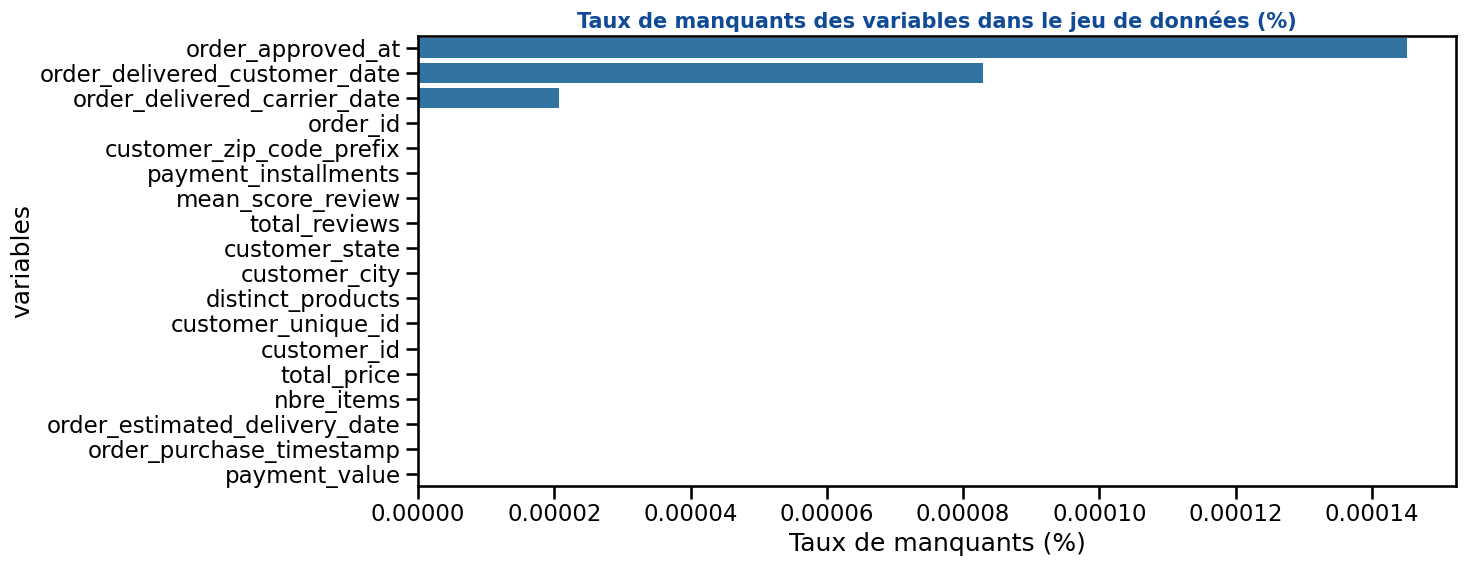

In [31]:
sns.set_context("talk")

vars = pd.DataFrame(data.isnull().mean(), columns=['Taux_de_Null']).sort_values(
    by='Taux_de_Null', ascending=False)
fig = plt.figure(figsize=(15, 6))

font_title = {'color':  '#114b98','weight': 'bold','size': 15}

sns.barplot(x=vars.Taux_de_Null, y=vars.index, data=vars)

# Seuil pour suppression des variables
# plt.axvline(x=max_threshold, linewidth=2, color = 'r')
# plt.text(max_threshold+0.1, 20, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de manquants des variables dans le jeu de données (%)",
          fontdict=font_title)
plt.xlabel("Taux de manquants (%)")
plt.ylabel("variables")

fig.tight_layout()

plt.show()

In [32]:
data.describe()

,nbre_items,total_price,distinct_products,customer_zip_code_prefix,total_reviews,mean_score_review,payment_installments,payment_value
count,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000
mean,1.142179,159.827008,1.038538,35198.398862,0.998787,4.128390,2.928024,159.856357
std,0.538773,218.795346,0.227943,29839.786348,0.110728,1.323427,2.712723,218.813144
min,1.000000,9.590000,1.000000,1003.000000,0.000000,0.000000,0.000000,9.590000
25%,1.000000,61.850000,1.000000,11355.000000,1.000000,4.000000,1.000000,61.880000
50%,1.000000,105.280000,1.000000,24435.000000,1.000000,5.000000,2.000000,105.280000
75%,1.000000,176.260000,1.000000,59056.000000,1.000000,5.000000,4.000000,176.330000
max,21.000000,13664.080000,8.000000,99980.000000,3.000000,5.000000,24.000000,13664.080000


In [10]:
data.describe(include='O')

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state
count,96477,96477,96477,96463,96475,96469,96477,96477,96477,96477
unique,96477,96477,95955,88273,80105,95657,444,93357,4085,27
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2018-08-02 12:06:07,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-02-14 21:09:19,2017-12-20 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,1,3,9,47,3,507,15,15045,40500


In [50]:
data.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,nbre_items,total_price,distinct_products,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_reviews,mean_score_review,payment_installments
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,38.71,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,4.0,1
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,141.46,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,4.0,1
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,179.12,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,5.0,3
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,72.20,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,5.0,1
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,28.62,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,5.0,1


## | Gestion des Valeurs manquantes

Nous avons remarqué plus haut que les trois varibales **order_approved_at**, **order_delivered_customer_date**, **order_delivered_carrier_date** presentent des valeurs manquantes qui devront etre imputer ou supprimer avant de poursuivre l'ananlyse.

L'approche que nous allons choisir consiste:

- Pour la variable **order_approved_at**: nous allons calculer le temps moyen entre order_purchase_timestamp (le moment où l'achat a été effectué) et order_approved_at (le moment où l'achat a été validé) puis ensuite nous allons imputer les valeur manquantes en addition order_purchase_timestamp avec la moyenne trouvée.

- Pour la variable **order_delivered_customer_date**: Nous allons calculer la moyenne entre cette variable et la date estimée de la livraison (**order_estimated_delivery_date**)

- Pour la variable **order_delivered_carrier_date**, on imputera les valeurs manquantes par la moyenne entre la date de validation et la variable.

In [83]:
missing_cols = data.columns[data.isnull().any()].tolist()
print(missing_cols)

['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
